In [ ]:
print("akurasi 75")

akurasi 90


In [1]:
import os
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
import cv2

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [2]:
import os
import zipfile
import pandas as pd

# Path dan ekstraksi
zip_path = "/content/drive/MyDrive/dataset_ppdm/dataset/images.zip"
extract_to = "/content/dataset_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Inisialisasi
base_path = "/content/dataset_images/images"
categories = ["Boot", "Sandal", "Shoe"]
image_paths = {}

# Kumpulkan path gambar
for category in categories:
    folder = os.path.join(base_path, category)
    if os.path.exists(folder):
        files = [os.path.join(folder, f) for f in os.listdir(folder)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"{category}: {len(files)} images found")
        image_paths[category] = files
    else:
        print(f"Missing folder: {folder}")
        image_paths[category] = []

# Buat DataFrame dari path dan label
data = []

for label, paths in image_paths.items():
    for path in paths:
        data.append({"path": path, "label": label})

df = pd.DataFrame(data)

# Lihat hasil
print(df.head())


Boot: 5000 images found
Sandal: 5000 images found
Shoe: 5000 images found
                                                path label
0  /content/dataset_images/images/Boot/boot (2376...  Boot
1  /content/dataset_images/images/Boot/boot (2691...  Boot
2  /content/dataset_images/images/Boot/boot (3220...  Boot
3  /content/dataset_images/images/Boot/boot (960)...  Boot
4  /content/dataset_images/images/Boot/boot (3631...  Boot


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Asumsikan df sudah ada, dengan kolom 'path' dan 'label'
# Contoh: df = pd.DataFrame({'path': [...], 'label': [...])

# Siapkan data grayscale
grayscaled_images = []
labels = []

for _, row in df.iterrows():
    img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (128, 128))
        grayscaled_images.append(img)
        labels.append(row['label'])

# Fungsi buat GLCM manual
def compute_glcm_manual(image, dx, dy, levels=256):
    glcm = np.zeros((levels, levels), dtype=np.uint32)

    rows, cols = image.shape

    # Tentukan batas i dan j agar tidak out of bounds
    if dy >= 0:
        i_range = range(rows - dy)
    else:
        i_range = range(-dy, rows)

    if dx >= 0:
        j_range = range(cols - dx)
    else:
        j_range = range(-dx, cols)

    for i in i_range:
        for j in j_range:
            row_val = image[i, j]
            col_val = image[i + dy, j + dx]
            glcm[row_val, col_val] += 1

    return glcm + glcm.T  # Buat symmetric (optional)

# Fungsi hitung fitur dari GLCM
def compute_glcm_features(glcm):
    glcm = glcm.astype(np.float64)
    glcm_sum = glcm.sum()
    if glcm_sum == 0:
        return [0] * 6
    glcm /= glcm_sum  # Normalisasi

    levels = glcm.shape[0]
    i, j = np.meshgrid(np.arange(levels), np.arange(levels), indexing='ij')

    contrast = np.sum((i - j) ** 2 * glcm)
    dissimilarity = np.sum(np.abs(i - j) * glcm)
    homogeneity = np.sum(glcm / (1.0 + (i - j) ** 2))
    asm = np.sum(glcm ** 2)
    energy = np.sqrt(asm)

    mi = np.sum(i * glcm)
    mj = np.sum(j * glcm)
    si = np.sqrt(np.sum((i - mi) ** 2 * glcm))
    sj = np.sqrt(np.sum((j - mj) ** 2 * glcm))
    if si > 0 and sj > 0:
        correlation = np.sum((i - mi) * (j - mj) * glcm) / (si * sj)
    else:
        correlation = 0

    return [contrast, dissimilarity, homogeneity, asm, energy, correlation]

# Arah GLCM manual: (dx, dy)
directions = {
    '0': (1, 0),
    '45': (1, -1),
    '90': (0, 1),
    '135': (-1, -1)
}

# Loop semua gambar
combined_features = []

for image, label in zip(grayscaled_images, labels):
    feature_dict = {}

    for suffix, (dx, dy) in directions.items():
        glcm = compute_glcm_manual(image, dx, dy)
        contrast, dissimilarity, homogeneity, asm, energy, correlation = compute_glcm_features(glcm)

        feature_dict[f'Contrast_{suffix}'] = contrast
        feature_dict[f'Dissimilarity_{suffix}'] = dissimilarity
        feature_dict[f'Homogeneity_{suffix}'] = homogeneity
        feature_dict[f'ASM_{suffix}'] = asm
        feature_dict[f'Energy_{suffix}'] = energy
        feature_dict[f'Correlation_{suffix}'] = correlation

    feature_dict['Class'] = label
    combined_features.append(feature_dict)

# Gabungkan ke DataFrame
df_combined = pd.DataFrame(combined_features)
df_combined

,Contrast_0,Dissimilarity_0,Homogeneity_0,ASM_0,Energy_0,Correlation_0,Contrast_45,Dissimilarity_45,Homogeneity_45,ASM_45,...,ASM_90,Energy_90,Correlation_90,Contrast_135,Dissimilarity_135,Homogeneity_135,ASM_135,Energy_135,Correlation_135,Class
0,205.374631,5.911294,0.513464,0.154267,0.392768,0.972388,331.831546,7.901978,0.480186,0.149387,...,0.159008,0.398758,0.974736,373.669477,8.464319,0.474758,0.149220,0.386290,0.949837,Boot
1,286.158342,4.425935,0.662691,0.247648,0.497642,0.984990,350.720317,5.323083,0.630646,0.243291,...,0.257868,0.507807,0.990305,521.659867,6.579453,0.619531,0.242464,0.492406,0.972723,Boot
2,234.131890,5.107899,0.651069,0.325237,0.570296,0.978567,323.022630,6.271685,0.634082,0.320875,...,0.332422,0.576560,0.987187,380.226052,7.037882,0.627963,0.318579,0.564428,0.965340,Boot
3,392.890256,7.903420,0.581410,0.258408,0.508339,0.961931,837.555521,11.546717,0.566467,0.251500,...,0.264158,0.513963,0.940001,942.530907,12.760432,0.558080,0.251906,0.501902,0.909072,Boot
4,137.168553,4.013041,0.656644,0.327868,0.572597,0.977691,174.758758,4.727757,0.640829,0.323538,...,0.338417,0.581737,0.982639,281.108686,6.017608,0.634678,0.323304,0.568598,0.954475,Boot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,172.136688,4.392963,0.676412,0.326066,0.571022,0.984145,287.508835,6.064480,0.644190,0.314534,...,0.323816,0.569048,0.980626,396.484221,6.686217,0.641790,0.312802,0.559287,0.963657,Shoe
14996,251.050750,4.522453,0.632083,0.193789,0.440215,0.989074,400.189534,5.641577,0.586088,0.186946,...,0.192296,0.438515,0.986382,605.461777,7.374109,0.568923,0.186435,0.431782,0.973688,Shoe
14997,239.978593,6.345103,0.534804,0.185942,0.431210,0.980710,426.295617,8.764834,0.503941,0.179870,...,0.185308,0.430474,0.975388,541.328663,9.669291,0.500703,0.179603,0.423796,0.956557,Shoe
14998,235.358206,5.550381,0.576671,0.193451,0.439831,0.983065,438.576539,7.783434,0.541664,0.182358,...,0.190357,0.436299,0.974895,604.269143,9.330585,0.535565,0.181210,0.425688,0.956658,Shoe


In [8]:
df_combined = pd.read_csv('df_combined.csv')

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class ManualSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, gamma=0.1, lr=0.001, epochs=1000):
        self.C = C
        self.gamma = gamma
        self.lr = lr
        self.epochs = epochs
        self.classifiers = {}

    def rbf_kernel(self, X1, X2):
        diff = X1 - X2
        return np.exp(-self.gamma * np.dot(diff, diff))

    def _train_binary(self, X, y_binary):
        n_samples = X.shape[0]
        alpha = np.zeros(n_samples)
        bias = 0

        # Precompute kernel
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.rbf_kernel(X[i], X[j])

        # Gradient descent
        for epoch in range(self.epochs):
            for i in range(n_samples):
                condition = y_binary[i] * (np.sum(alpha * y_binary * K[:, i]) + bias)
                if condition < 1:
                    alpha[i] += self.lr * (1 - condition)
                else:
                    alpha[i] -= self.lr * self.C * alpha[i]
            alpha = np.clip(alpha, 0, self.C)

        # Support vectors
        support_indices = np.where(alpha > 1e-5)[0]
        support_vectors = X[support_indices]
        support_alpha = alpha[support_indices]
        support_y = y_binary[support_indices]

        # Bias estimate
        bias = 0
        for i in support_indices:
            bias += y_binary[i] - np.sum(alpha * y_binary * K[:, i])
        bias /= len(support_indices)

        return {
            'alpha': support_alpha,
            'bias': bias,
            'support_vectors': support_vectors,
            'support_y': support_y
        }

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.classifiers = {}

        for cls in self.classes_:
            y_binary = np.where(y == cls, 1, -1)
            self.classifiers[cls] = self._train_binary(X, y_binary)

        return self

    def _project(self, x, clf):
        result = 0
        for alpha, sv_y, sv in zip(clf['alpha'], clf['support_y'], clf['support_vectors']):
            result += alpha * sv_y * self.rbf_kernel(x, sv)
        return result + clf['bias']

    def predict(self, X):
        scores = []
        for cls in self.classes_:
            clf = self.classifiers[cls]
            class_scores = np.array([self._project(x, clf) for x in X])
            scores.append(class_scores)

        scores = np.stack(scores, axis=1)  # shape: (n_samples, n_classes)
        return self.classes_[np.argmax(scores, axis=1)]

Accuracy: 0.7836666666666666
Classification Report:
              precision    recall  f1-score   support

        Boot       0.89      0.84      0.87      1000
      Sandal       0.73      0.73      0.73      1000
        Shoe       0.74      0.78      0.76      1000

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.79      0.78      0.78      3000



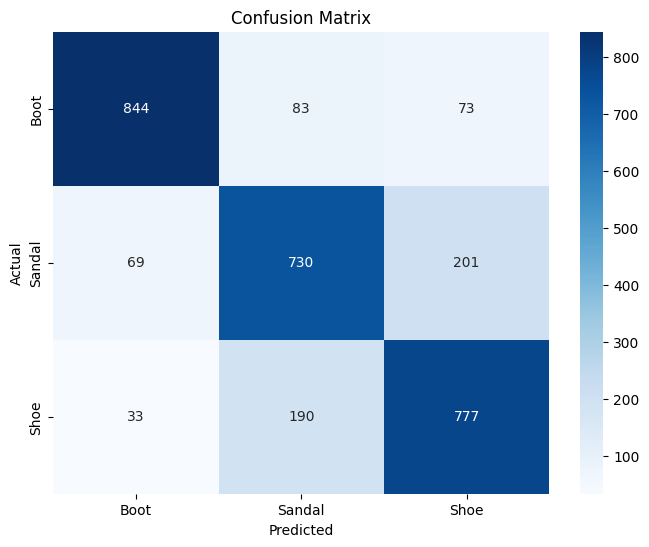

In [9]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Drop NaN
df_clean = df_combined.dropna()

# 2. Fitur dan label
X = df_clean.drop('Class', axis=1).values
y = df_clean['Class'].values

# 3. Encode label multi-class
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 5. Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_manual = ManualSVM(C=10, gamma=0.1, lr=0.001, epochs=500)
svm_manual.fit(X_train_scaled, y_train)

# 7. Prediksi
y_pred = svm_manual.predict(X_test_scaled)

# 8. Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 9. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
import pickle

# Misal: model telah dilatih, dan ini hasilnya
# classifiers = [...]    # List berisi model setiap kelas (alpha, b, gamma, y_binary)
# X_train = [...]        # Data training yang digunakan
# label_names = [...]    # Label class: misal ['Boot', 'Sandal', 'Shoe']

# Simpan model ke file

with open("svmmodel.pkl", "wb") as f:
    pickle.dump(svm_manual, f)

print("Model berhasil disimpan ke svmmodel.pkl")

Model berhasil disimpan ke svmmodel.pkl


In [12]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [30]:
from google.colab import files
import numpy as np
import cv2
from PIL import Image
import io
import pickle

with open("svmmodel.pkl", "rb") as f:
    model = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

def compute_glcm_manual(image, dx, dy, levels=256):
    glcm = np.zeros((levels, levels), dtype=np.uint32)
    rows, cols = image.shape

    if dy >= 0:
        i_range = range(rows - dy)
    else:
        i_range = range(-dy, rows)

    if dx >= 0:
        j_range = range(cols - dx)
    else:
        j_range = range(-dx, cols)

    for i in i_range:
        for j in j_range:
            row_val = image[i, j]
            col_val = image[i + dy, j + dx]
            glcm[row_val, col_val] += 1

    return glcm + glcm.T  # symmetric

def compute_glcm_features(glcm):
    glcm = glcm.astype(np.float64)
    glcm_sum = glcm.sum()
    if glcm_sum == 0:
        return [0] * 6
    glcm /= glcm_sum

    levels = glcm.shape[0]
    i, j = np.meshgrid(np.arange(levels), np.arange(levels), indexing='ij')

    contrast = np.sum((i - j) ** 2 * glcm)
    dissimilarity = np.sum(np.abs(i - j) * glcm)
    homogeneity = np.sum(glcm / (1.0 + (i - j) ** 2))
    asm = np.sum(glcm ** 2)
    energy = np.sqrt(asm)

    mi = np.sum(i * glcm)
    mj = np.sum(j * glcm)
    si = np.sqrt(np.sum((i - mi) ** 2 * glcm))
    sj = np.sqrt(np.sum((j - mj) ** 2 * glcm))
    correlation = np.sum((i - mi) * (j - mj) * glcm) / (si * sj) if si > 0 and sj > 0 else 0

    return [contrast, dissimilarity, homogeneity, asm, energy, correlation]

def extract_glcm_manual_all_directions(gray_image):
    directions = {
        '0': (1, 0),
        '45': (1, -1),
        '90': (0, 1),
        '135': (-1, -1)
    }

    features = []

    for _, (dx, dy) in directions.items():
        glcm = compute_glcm_manual(gray_image, dx, dy)
        features.extend(compute_glcm_features(glcm))

    return np.array(features)

def predict_from_uploaded_image(image_array):
    if image_array is None or not isinstance(image_array, np.ndarray):
        raise ValueError("Input harus berupa numpy.ndarray (gambar).")

    gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128, 128))

    features = extract_glcm_manual_all_directions(gray)
    features_scaled = scaler.transform([features])
    pred = model.predict(features_scaled)
    label = le.inverse_transform(pred)[0]
    return label

uploaded = files.upload()
for filename, filedata in uploaded.items():
    img_pil = Image.open(io.BytesIO(filedata)).convert('RGB')
    img_np = np.array(img_pil)
    img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    pred_label = predict_from_uploaded_image(img_cv2)
    print(f"Gambar '{filename}' diprediksi sebagai: {pred_label}")

Saving boot (23).jpg to boot (23) (1).jpg
Gambar 'boot (23) (1).jpg' diprediksi sebagai: Boot
